In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
#reading from file
T = np.loadtxt("transition.txt", delimiter='\t', dtype=np.float) 
M = np.loadtxt("emission.txt", delimiter='\t', dtype=np.float) 
F = np.loadtxt("beginning_distr.txt", delimiter='\t', dtype=np.float)

In [3]:
print(T) #transition matrix
print(M) # emission matrix
print(F) #initial distribution

[[ 0.95  0.05]
 [ 0.1   0.9 ]]
[[ 0.16666667  0.16666667  0.16666667  0.16666667  0.16666667  0.16666667]
 [ 0.1         0.1         0.1         0.1         0.1         0.5       ]]
[ 0.33333333  0.66666667]


In [4]:
#generation of state/emission sequences
def gen_outcome(probs, r):
    chance = 0
    for j, p in enumerate(probs):
        chance += p
        if (chance > r):
            return j

def gen_sequence(T,M,F,L):
    mt = np.random.RandomState(1234) #mersenne twister generator
    
    rnd = mt.random_sample()
    state = []
    state.append(gen_outcome(F,rnd))
    rnd = mt.random_sample()
    emission = []
    emission.append(gen_outcome(M[state[0]], rnd))
    
    for i in range(L):
        rnd = mt.random_sample()
        state.append(gen_outcome(T[state[-1]], rnd))             
        rnd = mt.random_sample()       
        emission.append(gen_outcome(M[state[-1]], rnd))
        
    return np.array(state), np.array(emission) 

In [5]:
L = 100
states,emis = gen_sequence(T,M,F,L)
print(states)
print(emis)

[0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[3 4 1 4 5 5 5 5 0 5 5 2 3 4 3 2 0 4 5 5 1 4 3 3 3 3 0 5 5 5 5 1 0 5 1 5 1
 5 5 1 3 3 0 4 2 3 5 3 4 4 4 3 1 3 5 1 5 1 1 4 5 3 0 3 0 3 1 0 1 5 5 5 1 0
 1 5 1 5 5 5 5 5 5 4 5 3 5 5 5 5 4 5 0 5 3 1 5 3 1 5 5]


In [6]:
# viterby algorithm
def viterby(T,M,F,L,y):
    states_num = T[0].size
    obs_num = M[0].size
    V1 = np.zeros((L,states_num))
    V2 = np.zeros((L,states_num))
    
    for i in range(states_num):
        V1[0,i] = F[i]*M[i,y[0]]
        
    for i in range(1,L):
        for st in range(states_num):
            max_tr_prob = V1[i-1,0]*T[0,st]
            prev_state = 0
            for state in range(1,states_num):
                tr_prob = V1[i-1,state]*T[state,st]
                if tr_prob > max_tr_prob:
                    max_tr_prob = tr_prob
                    prev_state = state

            V1[i][st] = max_tr_prob * M[st,y[i]]
            V2[i][st] = prev_state
            
    # Get most probable state and its backtrack       
    max_prob = max( p for p in V1[-1])
    opt_path = []
    for i in range(states_num):
        if V1[-1][i] == max_prob:
            prev = V2[-1][i]
            opt_path.append(prev)
            break
    for i in range(L-1, -1, -1):
        opt_path.insert(0, V2[i,int(prev)])
        prev = V2[i,int(prev)]
    
    #print(V1)
    #print(V2)
    return np.array(opt_path), max_prob

In [7]:
opt , prob = viterby(T,M,F,L,emis)
print(opt,'\n')
print(prob)
x = (opt - states)
x[abs(x)>0.1].size / L # percentage of error

[ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.] 

1.51045568871e-75


0.13

<IPython.core.display.Javascript object>


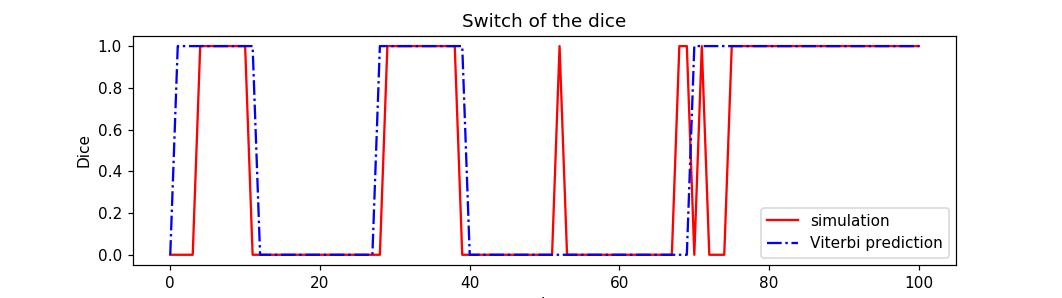

In [12]:
w = np.linspace(0, L,101)
fig, ax = plt.subplots()
ax.set_title('Switch of the dice')
ax.set_ylabel('Dice')
ax.set_xlabel('L')
ax.plot(w, states, label = 'simulation', color='r')
ax.plot(w, opt, '-.', label = 'Viterbi prediction',color='b')
ax.legend()
# the prediction is pretty good

In [18]:
# forward-backward algorithm
def fwd_bkw(obs, F, T, M,L):
    states_num = T[0].size
    obs_num = M[0].size
    fwd = np.zeros((L+1,states_num))
    bkw = np.zeros((L+1,states_num))
    
    # forward part
    f_curr = np.zeros(states_num)
    for i, obs_i in enumerate(obs):
        for st in range(states_num):
            if i == 0:
                prev_f_sum = F[st]
            else:
                prev_f_sum = M[st][obs_i] *math.fsum([f_prev[k]*T[k][st] for k in range(states_num)])

            f_curr[st] = prev_f_sum
            fwd[i,st] = f_curr[st]
 
        f_prev = f_curr
    
    p_fwd = math.fsum(f_curr) # P(x)

    # backward part
    b_curr = np.zeros(states_num)
    for i, obs_i in enumerate(obs[::-1]):
        for st in states:
            if i == 0:
                b_curr[st] = 1
                bkw[L-i,st] = b_curr[st]
            else:
                b_curr[st] = math.fsum([T[st][l] * M[l][obs_i] * b_prev[l] for l in range(states_num)])
                bkw[L-i,st] = b_curr[st]
                
        b_prev = b_curr

    p_bkw = math.fsum([F[l] * M[l][obs[0]] * b_curr[l] for l in range(states_num)])

    # calculating the posterior probability
    posterior = []
    for i in range(L):
        posterior.append( [fwd[i][st] * bkw[i][st] / p_fwd for st in range(states_num)])

    print(p_fwd,p_bkw)
    return fwd, bkw, np.array(posterior)

In [19]:
fwd,bkw ,post = fwd_bkw(emis,F,T,M,L)
print(post,'\n')
print(fwd,'\n')
print(bkw) #probably smth wrong here ...

7.732313309788245e-74 0.0
[[  0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000]

In [15]:
# logarithmic summation
def log_sum(arr):
    s = arr[0]
    for i in range(len(arr) - 1):
        s = math.log(s)+math.log1p(math.exp(math.log(arr[i+1])-math.log(s)))
        s = math.exp(s)
    return s

arr = np.array([i**2 for i in range(1,10)])
arr = arr[::-1]
print(arr)
print(sum(arr))
print(log_sum(arr))

[81 64 49 36 25 16  9  4  1]
285
285.00000000000006
